# Insurance Purchasing Analysis
Use classification techniques to identify the potential purchasers based on a Kaggle dataset from the real case.

In [46]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.8.0-py3-none-any.whl (206 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached scikit_learn-0.24.1-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Using cached numpy-1.20.1-cp37-cp37m-manylinux2010_x86_64.whl (15.3 MB)
  Using cached scipy-1.6.1-cp37-cp37m-manylinux1_x86_64.whl (27.4 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.6.1 which is incompatible.


## Load the data from IBM cloud

In [47]:
import ibmos2spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Insurance_Analysis").getOrCreate()
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-3cf147f6-84c7-43ab-b522-6b0af7c5567d',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'd0zPXxornqV9DL2e8xcLDoA-G8G60kfeGrAIDkidaVGq'
}

configuration_name = 'os_1cb3a8f78c2c4a129c3c68cea1ce623c_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')
caravan_insurance_raw2 = spark.read.csv(cos.url('caravan-insurance_2.csv', 'advanceddatasciencecapstone-donotdelete-pr-vdy06vb49sgqdo'), header=True, inferSchema=True)

In [48]:
# Import Libraries
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count,array,explode
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window
from pyspark.sql.types import Row

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler,ChiSqSelector, PCA,OneHotEncoder
from pyspark.ml.classification import LogisticRegression,GBTClassifier,LinearSVC, RandomForestClassifier, NaiveBayes, FMClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import Vectors,DenseVector
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

## Data Preprocessing and Cleaning
Here we checked missing/duplicated values and outliers (if any).

In [49]:
#caravan_insurance_pdf=caravan_insurance_raw.drop('ORIGIN')
caravan_insurance_pdf=caravan_insurance_raw2
caravan_insurance_pdf=caravan_insurance_pdf.withColumnRenamed('CARAVAN','label')
caravan_insurance_pdf.describe().toPandas()
caravan_insurance_pdf_copy=caravan_insurance_pdf.withColumnRenamed('CARAVAN','label')

In [50]:
# process duplicate and null value
#Note: If we have any missing values, we need to do imputation. For the dataset used here, it is N/A.
caravan_insurance_pdf=caravan_insurance_pdf.dropDuplicates(subset=[c for c in caravan_insurance_pdf.columns if c != 'ID'])
caravan_insurance_pdf=caravan_insurance_pdf.na.drop()
caravan_insurance_pdf=caravan_insurance_pdf.drop('ID')
# check sample size for different classes
print(caravan_insurance_pdf.count(),caravan_insurance_pdf.filter(col('label') == 1).count(),caravan_insurance_pdf.filter(col('label') == 0).count())

8950 578 8372


In [51]:
# print the dataset schema
caravan_insurance_pdf.printSchema()

root
 |-- ORIGIN: string (nullable = true)
 |-- MOSTYPE: integer (nullable = true)
 |-- MAANTHUI: integer (nullable = true)
 |-- MGEMOMV: integer (nullable = true)
 |-- MGEMLEEF: integer (nullable = true)
 |-- MOSHOOFD: integer (nullable = true)
 |-- MGODRK: integer (nullable = true)
 |-- MGODPR: integer (nullable = true)
 |-- MGODOV: integer (nullable = true)
 |-- MGODGE: integer (nullable = true)
 |-- MRELGE: integer (nullable = true)
 |-- MRELSA: integer (nullable = true)
 |-- MRELOV: integer (nullable = true)
 |-- MFALLEEN: integer (nullable = true)
 |-- MFGEKIND: integer (nullable = true)
 |-- MFWEKIND: integer (nullable = true)
 |-- MOPLHOOG: integer (nullable = true)
 |-- MOPLMIDD: integer (nullable = true)
 |-- MOPLLAAG: integer (nullable = true)
 |-- MBERHOOG: integer (nullable = true)
 |-- MBERZELF: integer (nullable = true)
 |-- MBERBOER: integer (nullable = true)
 |-- MBERMIDD: integer (nullable = true)
 |-- MBERARBG: integer (nullable = true)
 |-- MBERARBO: integer (nullab

## Exploratory Data Analysis
Based on the visualization, the main types of insurance purchasers were family with grown-ups and average family. The main age group concentrated on 40-50  years old.<br>
Numerical & categoical features both were showing correlation with their kind only.

In [52]:
df1=caravan_insurance_pdf_copy.groupby('MOSTYPE').agg(F.countDistinct('ID')).sort(F.col('count(ID)').desc()) #.show(50,False)
df2=caravan_insurance_pdf_copy.filter(col('label') == 0).groupby('MOSTYPE','label').agg(F.countDistinct('ID')).sort(F.col('count(ID)').desc()) #.show(50,False)
df3=caravan_insurance_pdf_copy.filter(col('label') == 1).groupby('MOSTYPE','label').agg(F.countDistinct('ID')).sort(F.col('count(ID)').desc()).show(50,False)
#print(df3)

+-------+-----+---------+
|MOSTYPE|label|count(ID)|
+-------+-----+---------+
|33     |1    |80       |
|8      |1    |72       |
|38     |1    |38       |
|39     |1    |37       |
|3      |1    |33       |
|12     |1    |28       |
|36     |1    |27       |
|1      |1    |26       |
|6      |1    |26       |
|13     |1    |25       |
|10     |1    |23       |
|37     |1    |19       |
|9      |1    |17       |
|11     |1    |16       |
|35     |1    |13       |
|32     |1    |12       |
|34     |1    |12       |
|2      |1    |11       |
|41     |1    |11       |
|31     |1    |11       |
|29     |1    |7        |
|25     |1    |6        |
|24     |1    |6        |
|22     |1    |6        |
|30     |1    |5        |
|7      |1    |5        |
|23     |1    |4        |
|4      |1    |3        |
|26     |1    |2        |
|20     |1    |2        |
|5      |1    |2        |
|27     |1    |1        |
+-------+-----+---------+



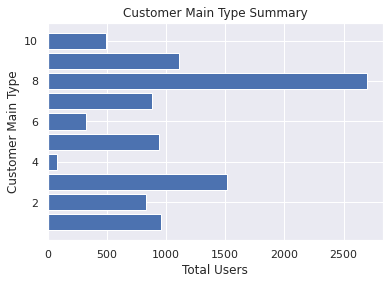

In [53]:
# Check the distribution for customer main type
main_count=caravan_insurance_pdf_copy.groupby('MOSHOOFD').agg(F.countDistinct('ID')).sort(F.col('MOSHOOFD').desc()).toPandas()
#print(main_count.head(5))
plt.barh(main_count['MOSHOOFD'],main_count['count(ID)'])
plt.ylabel('Customer Main Type')
plt.xlabel('Total Users')
plt.title('Customer Main Type Summary')
plt.show()

Customer Main Type List:<br>
1 Successful hedonists <br>
2 Driven Growers<br>
3 Average Family<br>
4 Career Loners<br>
5 Living well<br>
6 Cruising Seniors<br>
7 Retired and Religeous<br>
8 Family with grown ups<br>
9 Conservative families<br>
10 Farmers

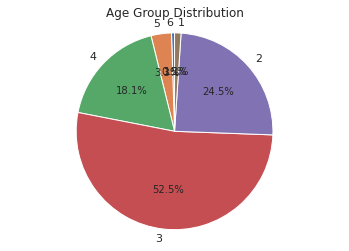

In [55]:
# Check the distribution for age groups 
age_count=caravan_insurance_pdf_copy.groupby('MGEMLEEF').agg(F.countDistinct('ID')).sort(F.col('MGEMLEEF').desc()).toPandas()
fig1, ax1 = plt.subplots()
plt.pie(age_count['count(ID)'],labels=age_count['MGEMLEEF'], autopct='%1.1f%%',shadow=False, startangle=90)
plt.axis('equal')
#plt.ylabel('Customer Main Type')
#plt.xlabel('Total Users')
plt.title('Age Group Distribution')
plt.show()

Age Group List:<br>
1 20-30 years<br>
2 30-40 years<br>
3 40-50 years<br>
4 50-60 years<br>
5 60-70 years<br>
6 70-80 years<br>

/opt/ibm/conda/miniconda/lib/python/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


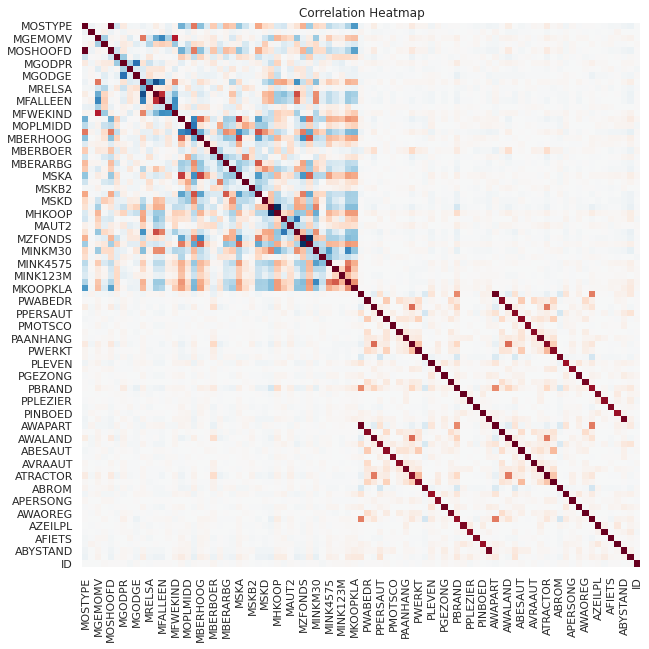

In [56]:
# Get correlations
sns.set(rc={'figure.figsize':(10,10)},font_scale=1)
df=caravan_insurance_pdf_copy.toPandas().drop('ORIGIN',axis=1)
sns.heatmap(df.corr(),cmap='RdBu_r',cbar=None,ax=plt.axes())
plt.axes().set_title('Correlation Heatmap')
plt.show()

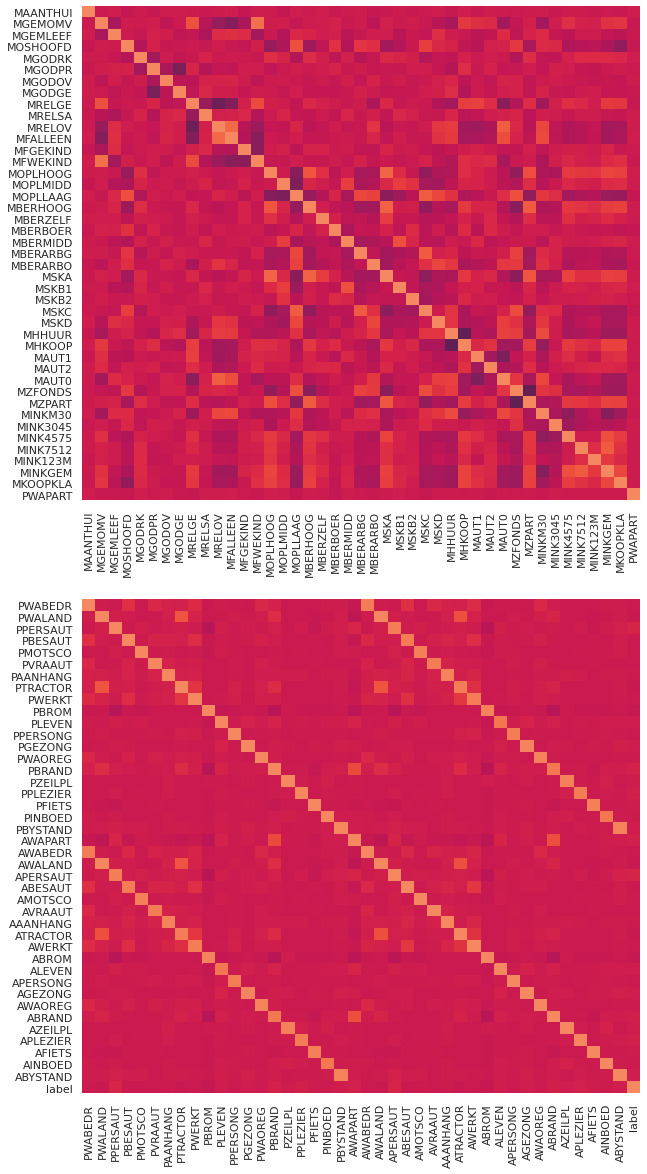

In [57]:
f,axs=plt.subplots(2,1,figsize=(10,20))
sns.heatmap(df.iloc[:,1:44].corr(),ax=axs[0],vmin=-2, vmax=2,cbar=None)
sns.heatmap(df.iloc[:,44:-1].corr(),ax=axs[1],vmin=-2, vmax=2,cbar=None)

## Training/test Set Split & Imbalanced Data Processing

As data is imbalanced, we can use re-sampling techniques (over-sampling, under-sampling, combined).<br>
Here I chose:
 - Over-Sampling (SMOTE)

In [58]:
#Filter_VarianceThreshold=0 
var = caravan_insurance_pdf.select([F.variance(col) for col in caravan_insurance_pdf.columns]).toPandas() #collect()
caravan_insurance_pdf_2 = caravan_insurance_pdf.select([col for col_id, col in enumerate(caravan_insurance_pdf.columns) if var['var_samp('+col+')'][0]!=0])

# split the data to get training and test sets
#train_org, test = caravan_insurance_pdf_2.randomSplit([0.7, 0.3], seed=42)
# instead, we use the default training and test set
train_org=caravan_insurance_pdf_2.filter(col("ORIGIN")=="train").drop("ORIGIN")
test=caravan_insurance_pdf_2.filter(col("ORIGIN")=="test").drop("ORIGIN")
print("training set, label=1",train_org.filter(col("label")=="1").count(),"training set, label=0",train_org.filter(col("label")=="0").count())
print("test set, label=1",test.filter(col("label")=="1").count(),"test set, label=0",test.filter(col("label")=="0").count())

training set, label=1 340 training set, label=0 4880
test set, label=1 238 test set, label=0 3492


In [59]:
#SMOTE with imblearn
y_base=train_org.select('label').toPandas()
base=train_org.drop('label').toPandas()
sm_trainX , sm_trainY = SMOTE(random_state=42).fit_resample(base,y_base)
train_sm=pd.concat([sm_trainX,sm_trainY],axis=1)
#print(train_sm)

In [60]:
# simplified over-sampling method
major_df=train_org.filter(col("label")==0)
minor_df=train_org.filter(col("label")==1)
ratio=int(major_df.count()/minor_df.count())
print(major_df.count())
print(minor_df.count())
print("ratio: {}".format(ratio))
#Oversampling
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
print(oversampled_df.filter(col("label") == 1).count())

# combine both oversampled minority rows and previous majority rows 
train_oversampled = major_df.unionAll(oversampled_df)

print(train_oversampled.count())
#oversampled_df_2.take(5)

# #Undersampling
# reduced_majority_df=major_df.sample(False, 1/ratio)
# Undersampled_df=reduced_majority_df.unionAll(minor_df)
# Undersampled_df.count()

4880
340
ratio: 14
4760
9640


In [61]:
#training sets prepared in different ways, here I only trained SMOTE
train_base=train_org
# train_simpOS=train_oversampled
train_SMOTE=spark.createDataFrame(train_sm)
#print(train_SMOTE.filter(col("label") == 1).take(5))

## Feature Engineering 
I chose the target mean encoding method instead of one-hot encoding for the variable 'MOSTYPE' since we already have 86 variables and 'MOSTYPE' has 41 distinct values.<br>
Some other technics used in building the pipeline: VectorAssembler,StandardScaler, etc.

In [62]:
print(train_org.columns[43:-1])

['PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED', 'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND']


In [63]:
# # pipeline with onehot encoding 
# columns_num=train_org.columns[43:-1]
# columns_cat=["MOSTYPE", "MOSHOOFD"]
# columns_all=["MOSTYPE_ONE", "MOSHOOFD_ONE","features_num_scaled"]
# encoder = OneHotEncoder(inputCols=columns_cat,
#                         outputCols=["MOSTYPE_ONE", "MOSHOOFD_ONE"])
# assembler_num = VectorAssembler(inputCols=columns_num, outputCol='features_num',handleInvalid = 'skip') 
# scalers = StandardScaler(inputCol='features_num', outputCol='features_num_scaled') 
# assembler_all = VectorAssembler(inputCols=columns_all, outputCol='features',handleInvalid = 'skip') 
# full_pipeline = Pipeline(stages=[encoder,assembler_num,scalers,assembler_all,model])   

In [64]:
# Build feature engineering pipeline
# columns_num=train_org.columns[43:-1]
# columns_cat=train_org.columns[:43]
# assembler_num = VectorAssembler(inputCols=columns_num, outputCol='features_num',handleInvalid = 'skip') 
# scalers = StandardScaler(inputCol='features_num', outputCol='features_num_scaled') 
# assembler_all = VectorAssembler(inputCols=columns_all, outputCol='features',handleInvalid = 'skip') 
#selector = ChiSqSelector(fpr=0.05,featuresCol='features_scaled',outputCol="features")#numTopFeatures=84

# process categorical variables - target mean encoding
def target_mean_encoding(df, col, target):
    """
    :param df: pyspark.sql.dataframe
        dataframe to apply target mean encoding
    :param col: str list
        list of columns to apply target encoding
    :param target: str
        target column
    :return:
        dataframe with target encoded columns
    """
    target_encoded_columns_list = []
    for c in col:
        means = df.groupby(F.col(c)).agg(F.mean(target).alias(f"{c}_mean_encoding"))
        dict_ = means.toPandas().to_dict()
        target_encoded_columns = [F.when(F.col(c) == v, encoder)
                                  for v, encoder in zip(dict_[c].values(),
                                                        dict_[f"{c}_mean_encoding"].values())]
        target_encoded_columns_list.append(F.coalesce(*target_encoded_columns).alias(f"{c}_mean_encoding"))
    return df, df.select(*df.columns, *target_encoded_columns_list)


# function apply on spark inputs
# train_base
train_target_encoded_1 = target_mean_encoding(train_base, col=['MOSTYPE', 'MOSHOOFD'], target='label')
train_encoded_col_1=train_target_encoded_1[1].drop('MOSTYPE', 'MOSHOOFD')

#train_SMOTE
train_target_encoded_2 = target_mean_encoding(train_SMOTE, col=['MOSTYPE', 'MOSHOOFD'], target='label')
train_encoded_col_2=train_target_encoded_2[1].drop('MOSTYPE', 'MOSHOOFD')

# since this part is not in the pipeline, 
test_target_encoded = target_mean_encoding(test, col=['MOSTYPE', 'MOSHOOFD'], target='label')
test_encoded_withlabel=test_target_encoded[1].drop('MOSTYPE', 'MOSHOOFD')

In [65]:
#print(train_encoded_col_2.columns)
print('numerical features:', train_encoded_col_2.columns[41:-3])
print('categorical features:', train_encoded_col_2.columns[:41]+train_encoded_col_2.columns[-2:])

numerical features: ['PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED', 'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND']
categorical features: ['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MGODRK', 'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN', 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG', 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2', 'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'MOSTYPE_mean_encoding', 'MOSHOOFD_mean_encoding']


In [66]:
columns_num=train_encoded_col_2.columns[41:-3]
columns_col=train_encoded_col_2.columns[:41]+train_encoded_col_2.columns[-2:]
assembler_num = VectorAssembler(inputCols=columns_num, outputCol='features_num',handleInvalid = 'skip') 
scalers = StandardScaler(inputCol='features_num', outputCol='features_num_scaled') 
assembler_col = VectorAssembler(inputCols=columns_col, outputCol='features_col',handleInvalid = 'skip') 
columns_all=['features_col','features_num']
assembler_all = VectorAssembler(inputCols=columns_all, outputCol='features',handleInvalid = 'skip')           
#selector = ChiSqSelector(fpr=0.05,featuresCol='features_scaled',outputCol="features")#numTopFeatures=84

## Modeling
To get better results, different classification techniques were applied.
  - Logistic Regression
  - Linear SVC
  - Naive Bayes Classifier
  - Random Forest Classifier
  - FM Classifier
<hr>

In [67]:
# if you will use tree model and chi-square selector at the same time, choose another function
def fit_model(df,model, paramGrid = None):
    # Model fitting with selected model and paramgric(optional)
    # Input: model, paramgrid
    # Output: fitted model, prediction on validation set
    full_pipeline = Pipeline(stages=[assembler_num,scalers,assembler_col,assembler_all,model])    
    if paramGrid != None:
        crossval_1 = CrossValidator(estimator=full_pipeline, 
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),#labelCol="CARAVAN"
                          numFolds=5)
        fitmodel = crossval_1.fit(df)
    else:
        
        fitmodel = full_pipeline.fit(df)
    
    results = fitmodel.transform(test_encoded_withlabel) 
    
    return fitmodel, results

def fit_model_tree_withchisquare (model, paramGrid = None):
    # Model fitting with selected model and paramgric(optional)
    # Input: model, paramgrid
    # Output: fitted model, prediction on validation set
    feature_pipeline=Pipeline(stages=[assembler, scalers,selector]) 
    FeatureModel = feature_pipeline.fit(train_encoded_withlabel)
    train_feature_processed = FeatureModel.transform(train_encoded_withlabel) 
    # convert sparse vector to dense vector
    data_modeling = train_feature_processed.select("label", "features")
    rdd = data_modeling.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
    data_modeling_Dense = sqlContext.createDataFrame(rdd)
    
    
    if paramGrid != None:
        crossval_1 = CrossValidator(estimator=model, #data was procsssed, otherwise a whole pipeline can be put here instead
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)
        fitmodel = crossval_1.fit(data_modeling_Dense)
    else:
        
        fitmodel = model.fit(data_modeling_Dense)
    
    # transform test data first

    test_feature_processed=FeatureModel.transform(test_encoded_withlabel)
    test_processed = test_feature_processed.select("label", "features")
    rdd2 = test_processed.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
    test_processed_Dense = sqlContext.createDataFrame(rdd2)
    results = fitmodel.transform(test_processed_Dense) 
    
    return fitmodel, results

In [68]:
#Evaluate the model on test set
def val_evaluation_imbalanced(results,df):
    # Input: prediction results
    # Output: accuracy, precision and recall score
    predictionAndLabels = results.select(['prediction', 'label']\
                                      ).withColumn('label',col('label').cast(DoubleType())).rdd

    metrics = MulticlassMetrics(predictionAndLabels)
    cm=metrics.confusionMatrix().toArray()
   
    
    # Use confusion matrix to calculate evaluation metrics
    # accuracy: (TP+TN)/Total Predictions
    # For class 1:
    # precision: TP/(TP + FP)
    # recall: TP/(TP + FN)
    # f1 score: 2*(Recall * Precision) / (Recall + Precision)
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision_1=(cm[1][1])/(cm[0][1]+cm[1][1])
    recall_1=(cm[1][1])/(cm[1][0]+cm[1][1])
    f1 = MulticlassClassificationEvaluator().evaluate(results)
    # For class 0:
    # precision: TN/(TN + FN)
    # recall: TN/(TN + FP)
    precision_0=(cm[0][0])/(cm[1][0]+cm[0][0])
    recall_0=(cm[0][0])/(cm[0][1]+cm[0][0])
    ratio=df.filter(col("label")=="1").count()/df.count()
    precision=ratio*precision_1+(1-ratio)*precision_0
    recall=ratio*recall_1+(1-ratio)*recall_0
    return(round(f1,2), round(accuracy,2),round(precision,2),round(recall,2),cm)

# # Evaluate the model on test set
# def val_evaluation(results):
#     # Input: prediction results
#     # Output: accuracy, precision and recall score
#     predictionAndLabels = results.select(['prediction', 'label']\
#                                       ).withColumn('label',col('label').cast(DoubleType())).rdd

#     metrics = MulticlassMetrics(predictionAndLabels)
#     cm=metrics.confusionMatrix().toArray()
   
    
#     # Use confusion matrix to calculate evaluation metrics
#     # accuracy: (TP+TN)/Total Predictions
#     # precision: TP/(TP + FP)
#     # recall: TP/(TP + FN)
#     # f1 score: 2*(Recall * Precision) / (Recall + Precision)
#     accuracy=(cm[0][0]+cm[1][1])/cm.sum()
#     precision=(cm[1][1])/(cm[0][1]+cm[1][1])
#     recall=(cm[1][1])/(cm[1][0]+cm[1][1])
#     f1 = MulticlassClassificationEvaluator().evaluate(results)
#     return(round(f1,2), round(accuracy,2),round(precision,2),round(recall,2),cm)

In [69]:
# use default params to run algorithms first
lr = LogisticRegression()
lsvc = LinearSVC()
nb = NaiveBayes()
rf = RandomForestClassifier()
gbt = GBTClassifier()
fm = FMClassifier()
#models=list([lr,lsvc,nb,rf,gbt,fm])

In [70]:
print("LogisticRegression parameters:\n"+ lr.explainParams()+ "\n" )
print("*****************************************************************")
print("LinearSVC parameters:\n"+ lsvc.explainParams()+ "\n")
print("*****************************************************************")
print("NaiveBayes parameters:\n"+ nb.explainParams()+ "\n")
print("*****************************************************************")
print("RandomForest parameters:\n"+ rf.explainParams()+ "\n")
print("*****************************************************************")
print("GBT parameters:\n"+ gbt.explainParams()+ "\n")
print("*****************************************************************")
print("FMC parameters:\n"+ fm.explainParams()+ "\n")

LogisticRegression parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bou

In [72]:
lrmodel_smote,lrresults_smote=fit_model(train_encoded_col_2,lr,None)
print("LogisticRegressionClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg)", val_evaluation_imbalanced(lrresults_smote,test_encoded_withlabel)[0:4])
lsvcmodel_smote,lsvcresults_smote=fit_model(train_encoded_col_2,lsvc,None)
print("LinearSVC_SMOTE: f1_score, accuracy,precision(avg),recall(avg)", val_evaluation_imbalanced(lsvcresults_smote,test_encoded_withlabel)[0:4])
nbmodel_smote,nbresults_smote=fit_model(train_encoded_col_2,nb,None)
print("NaiveBayesClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg)", val_evaluation_imbalanced(nbresults_smote,test_encoded_withlabel)[0:4])
rfmodel_smote,rfresults_smote=fit_model(train_encoded_col_2,rf,None)
print("RandomForestClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg)", val_evaluation_imbalanced(rfresults_smote,test_encoded_withlabel)[0:4])
#print("confusion metrics",val_evaluation(rfresults_smote,test)[4])
gbtmodel_smote,gbtresults_smote=fit_model(train_encoded_col_2,gbt,None)
print("GBTClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg)", val_evaluation_imbalanced(gbtresults_smote,test_encoded_withlabel)[0:4])
fmmodel_smote,fmresults_smote=fit_model(train_encoded_col_2,fm,None)
print("FMClassifierClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg)", val_evaluation_imbalanced(fmresults_smote,test_encoded_withlabel)[0:4])

LogisticRegressionClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg) (0.9, 0.93, 0.88, 0.93)
LinearSVC_SMOTE: f1_score, accuracy,precision(avg),recall(avg) (0.9, 0.94, 0.88, 0.94)
NaiveBayesClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg) (0.77, 0.69, 0.91, 0.69)
RandomForestClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg) (0.91, 0.92, 0.89, 0.92)
GBTClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg) (0.9, 0.91, 0.88, 0.91)
FMClassifierClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg) (0.84, 0.79, 0.9, 0.79)


## Model Tuning

Based on the performance for different algorithms, Logistics Regression and Random Forest were selected for further investigation.

### Logistic Regression

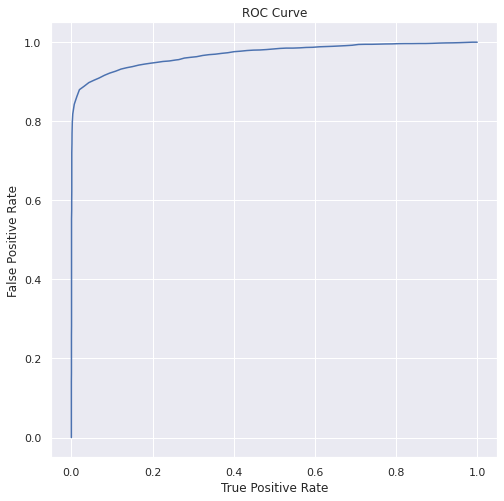

Training set area Under ROC: 0.9695643392233273


In [98]:
# lr model ROC curve
trainingSummary = lrmodel_smote.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.gcf().set_size_inches(8, 8)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area Under ROC: ' + str(trainingSummary.areaUnderROC))

In [81]:
# Extract feature names from the original data
dict_feats = lrresults_smote.schema['features'].metadata['ml_attr']['attrs']['numeric']
list_feats = np.array([x['name'] for x in dict_feats])
print(list_feats )

['features_col_MAANTHUI' 'features_col_MGEMOMV' 'features_col_MGEMLEEF'
 'features_col_MGODRK' 'features_col_MGODPR' 'features_col_MGODOV'
 'features_col_MGODGE' 'features_col_MRELGE' 'features_col_MRELSA'
 'features_col_MRELOV' 'features_col_MFALLEEN' 'features_col_MFGEKIND'
 'features_col_MFWEKIND' 'features_col_MOPLHOOG' 'features_col_MOPLMIDD'
 'features_col_MOPLLAAG' 'features_col_MBERHOOG' 'features_col_MBERZELF'
 'features_col_MBERBOER' 'features_col_MBERMIDD' 'features_col_MBERARBG'
 'features_col_MBERARBO' 'features_col_MSKA' 'features_col_MSKB1'
 'features_col_MSKB2' 'features_col_MSKC' 'features_col_MSKD'
 'features_col_MHHUUR' 'features_col_MHKOOP' 'features_col_MAUT1'
 'features_col_MAUT2' 'features_col_MAUT0' 'features_col_MZFONDS'
 'features_col_MZPART' 'features_col_MINKM30' 'features_col_MINK3045'
 'features_col_MINK4575' 'features_col_MINK7512' 'features_col_MINK123M'
 'features_col_MINKGEM' 'features_col_MKOOPKLA'
 'features_col_MOSTYPE_mean_encoding'
 'features_col_

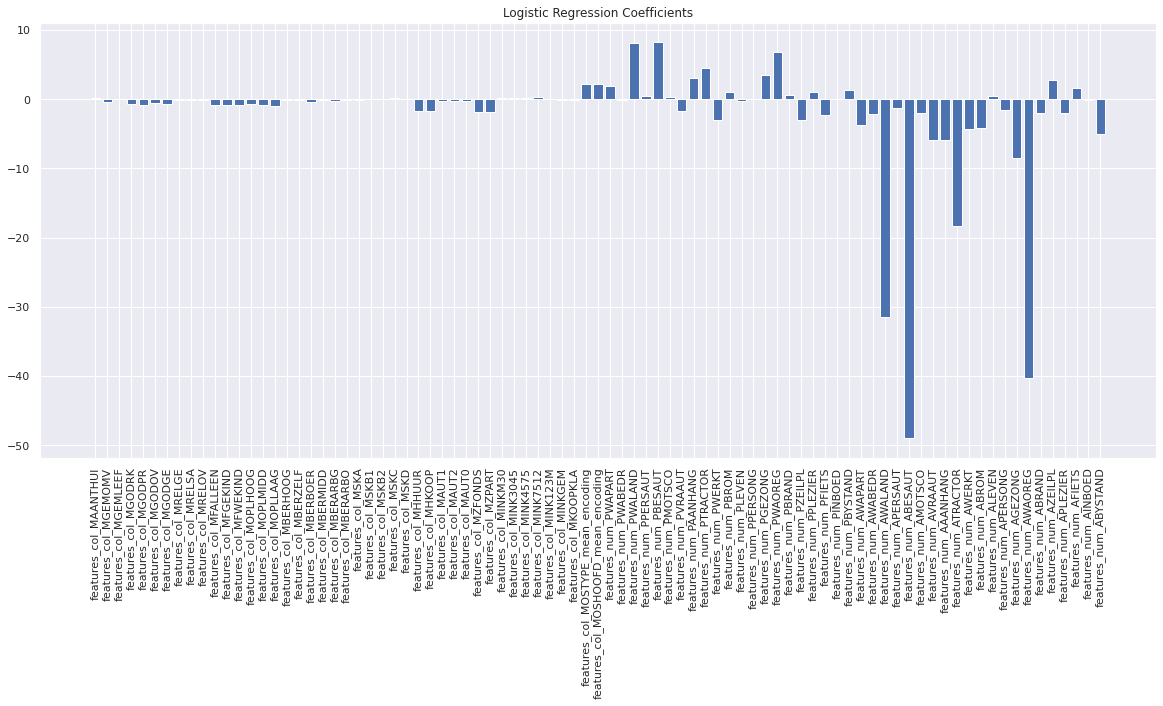

In [84]:
# Get coefficients
lr_corr = lrmodel_smote.stages[-1].coefficients
plt.gcf().set_size_inches(20, 8)
plt.bar(list_feats,lr_corr)
plt.xticks(rotation='vertical')
plt.title('Logistic Regression Coefficients')
plt.show()

In [86]:
# Get best threshold for current lr model
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
print(bestThreshold)

0.6196875477178173


### Random Forest

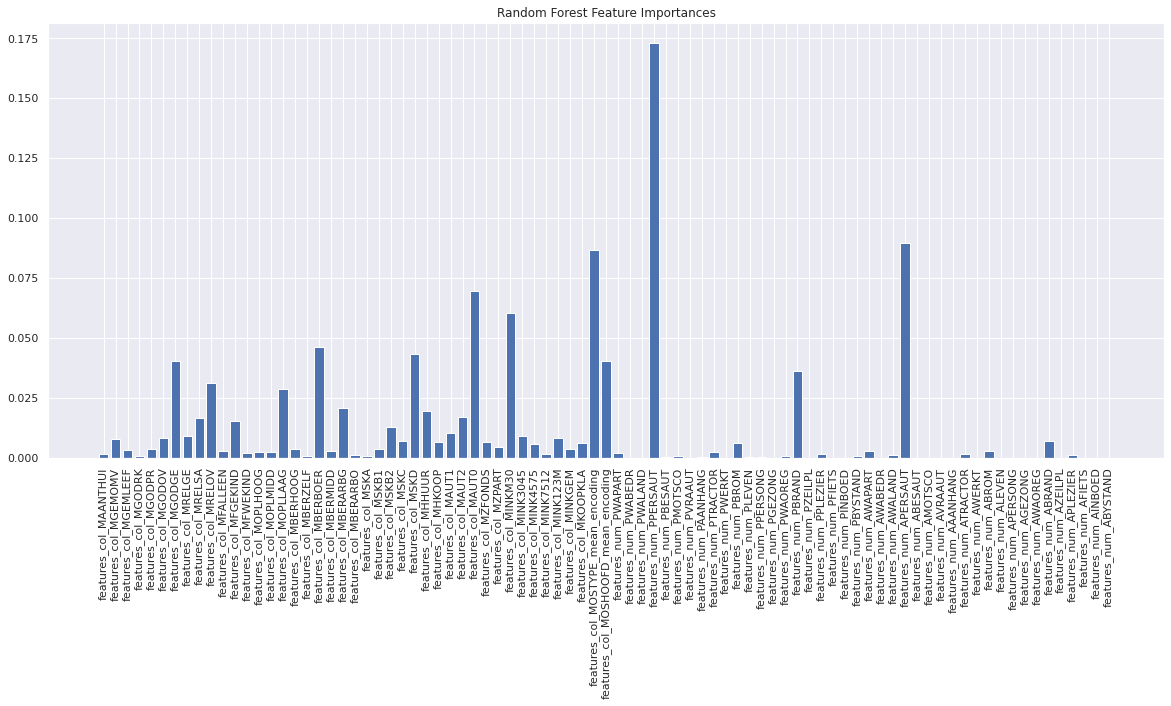

In [91]:
# Extract feature importance from rfmodel
featImportances = np.array(rfmodel_smote.stages[-1].featureImportances)
plt.gcf().set_size_inches(20, 8)
plt.bar(list_feats,featImportances)
plt.xticks(rotation='vertical')
plt.title('Random Forest Feature Importances')
plt.show()

In [92]:
# tune the hyper-parameters for the RF model
# tuning order: n_estimators, max_leaf_models/max_depth/min_samle_split and min_sample_leaf , tune 'subsmaple' & 'learning rate'
rf_paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 30, 50,70]).addGrid(rf.maxDepth, [5,10,20]).build()
rfmodel_smote_tuned,rfresults_smote_tuned=fit_model(train_encoded_col_2,rf,rf_paramGrid)

In [94]:
bestPipeline = rfmodel_smote_tuned.bestModel
bestRFModel = bestPipeline.stages[-1]
bestParams = bestRFModel.extractParamMap()
print(bestParams) #max depth 20, numtrees 30

{Param(parent='RandomForestClassifier_cdd0034690a8', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_cdd0034690a8', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_cdd0034690a8', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_cdd0034690a8', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Support

In [96]:
rf_best = RandomForestClassifier(numTrees=30, maxDepth=20)
rfmodel_smote_tuned,rfresults_smote_tuned=fit_model(train_encoded_col_2,rf_best,None)
print("RandomForestClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg)", val_evaluation_imbalanced(rfresults_smote_tuned,test_encoded_withlabel)[0:4])

RandomForestClassifier_SMOTE: f1_score, accuracy,precision(avg),recall(avg) (0.91, 0.93, 0.89, 0.93)


### Some ideas for further model improvement:<br>
Use a combined re-smapling method - SMOTE & TomekLinks<br>
Use algorithms with the base estimator (e.g.Easy Ensemble Classifier, RUS Boost Classifier)<br>
Train the model with different feature selection methods (e.g. variance threshold filter, feature selection based on the feature importance in LR/RF model)<br>
Tune the model in a more refined way (e.g use the range() function instead of a given list)